# **HOMEWORK 2: REAL ESTATE PRICE PREDICTION (Total: / 25 points)**

# *Names: (Sihoon Yu, Ji Qi)*

Make sure that you answer the two conceptual questions provided at the front of the notebook (edit the XXX response sections to provide your answers). You probably want to answer these last, after you finish the hands-on portion of the assignment. 

# *Background: Use Case*

Your task here is to use the supplied dataset describing homes, including four photos per home and some other structured features, along with an associated home sale price label, to try to fit a predictive model of sale price.

The use case here is as follows. Your customers are individual sellers, buyers, and real estate agent, who wishes to set their sale price, or their offer price on a new home. You can assume the user will always have these features available to them at the time of prediction (i.e., the four photo types in question, as well as the structured features). 

# **Answers to Written Questions (2 points)**

**Question 1: Why is it necessaty to resize the images? What impact, conceptually, would the choice of image size have on the prediction task, computationally / practically, but also in terms of prediction performnace (note: I'm not asking you try out different sizes to see what happens; I'm asking you to think about 'why' a choice of a smaller vs. larger image resizing would matter.)**

- Resizing the images to a same size is a cruical step for the neural networks, since the NN model receive the inputs of the same size. In general, large image size means less shrinking and less deformation of features, which in turn increase the classification accuracy.But, the large image size increases the training time due to the large NN and occupy more memory. Therefore, we need to balance between efficiency and accuracy based on the current situation.

**Question 2: Are there any predictors that you decided to discard here (numeric or image-based)? Why or why not; what did you consider when making these choices? Did you add any features? What, and why?**

- Our dataset has two types of features, numeric and image-based. For the numeric predictors, this dataset only has 4 predictors, but these 4 have different ranges and the distribution of all don't follow a Gaussian distribution. Thus, in order to reduce the probability that some predictor (area) may have more weights on the prediction, we add batchnormalization layer within our numeric branch model after the input layer. Especially, for zipcode, we try the one-hot encoding, but the MAE didn't show a good improvement. So, we still keep our zipcode as original because of less training time.

- For the imaged based predictors, in total, it has 535 X 4 images, so we decide split our dataset into train (80%) and validation (20%) without the holdout test set, since it still isn't enough to train a good model with only around 500 X 4 images. In addition, we try to resize each one at different image sizes (200 X 200, 180 X 180, 128 X 128) to compare the MAEs. We found that there aren't obvious decrease for MAE. So, we chose the smaller one, which reduces the training time period.

- For the modeling part, we used padding to prevent the tranformation of downsampling and max-pooling to reduce the model complexity and overfitting. In addition, for our Model 2, we try to add the data augmentation and dropout layer, which helps reduces val_mae from 321694.3438 to 317573.5312 and prevent the overfitting. Especially, I use the earlystopping feature from callback to monitor the training process, which could also reduce the training period.

- For our pretrained model, I chose the vgg16 and fine-tune the pretrained model by freezing all layers until the fifth from the last one. Finally, the mae result decreases from 317573.5312 to  315840.84375, even though the mae is not good for the prediction purpose.

# **Importing the Data**

I've provided some starter code for importing the data...

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


The shape of our kitchen image array is (535, 128, 128, 3)


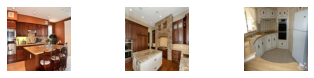

In [82]:
import tensorflow as tf
import pandas as pd
import numpy as np
#from google.colab import drive
import matplotlib.pyplot as plt
import glob
from PIL import Image


# Replace with your basepath to the extracted dataset in your Google Drive
#basePath = '/gdrive/MyDrive/BA865 Deep Learning/Dataset' 
basePath = '/Users/moonqj/Desktop/BA 865/BA865-2022/Week 5/datasets/Houses Dataset'

# These are the column headers for the home characteristics data.
cols = ['bedrooms','bathrooms','area','zipcode','price']

# We first pull in the numeric features for houses from the text file.
numericData = pd.read_csv(f'{basePath}/all/HousesInfo.txt', sep=" ", header=None, names=cols)

# Pulling out the labels
labels = numericData['price']

image_size = (128,128) # set the image size at 128 X 128 for all

# Reading the images into memory may take a minute - be patient :).
def read_images(imageType):
  image_list = []
  for file in glob.glob(f"{basePath}/all/{imageType}/*"):
    im=Image.open(file)
    im=im.resize(size=image_size)
    image_list.append(np.divide(np.array(im),255))
  return np.stack(image_list)

front_image = read_images("frontal")
bathroom_image = read_images("bathroom")
bedroom_image = read_images("bedroom")
kitchen_image = read_images("kitchen")

print(f'The shape of our kitchen image array is {kitchen_image.shape}')

# Our 535 houses' images are all now in memory as 200x200 pictures, with 3 channels (RGB). Feel free to change the image size.
for i in range(3):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(kitchen_image[i])
    plt.axis("off")

In [83]:
n_copy = numericData

In [84]:
n_copy.describe()

,bedrooms,bathrooms,area,zipcode,price
count,535.000000,535.000000,535.000000,535.000000,5.350000e+02
mean,3.377570,2.664953,2364.904673,90937.770093,5.893628e+05
std,1.160952,0.995077,1224.556982,7141.843144,5.090261e+05
min,1.000000,1.000000,701.000000,36373.000000,2.200000e+04
25%,3.000000,2.000000,1440.000000,92276.000000,2.492000e+05
50%,3.000000,2.500000,2078.000000,92880.000000,5.290000e+05
75%,4.000000,3.000000,3067.500000,93510.000000,7.285000e+05
max,10.000000,7.000000,9583.000000,98021.000000,5.858000e+06


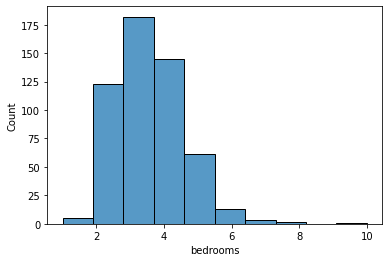

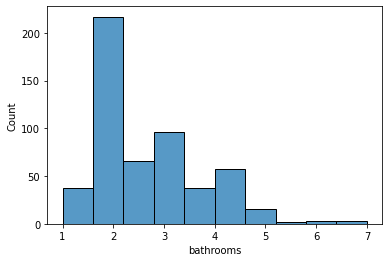

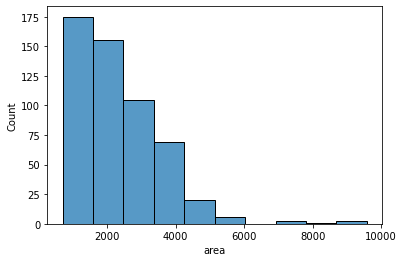

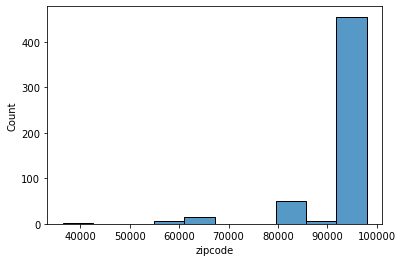

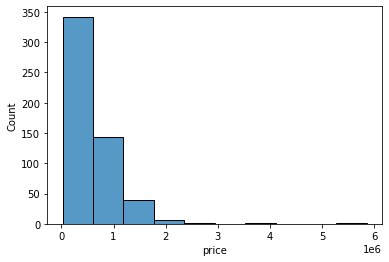

In [85]:
import seaborn as sns

def hist(x):
    sns.histplot(n_copy[x], bins =10)
    plt.show()

for i in n_copy.columns:
    hist(i)

Shuffle the different arrays, in unison (preserving row ordering across the arrays).

In [86]:
shuffled_indices= np.arange(front_image.shape[0])
np.random.shuffle(shuffled_indices)

front_image = front_image[shuffled_indices]
kitchen_image = kitchen_image[shuffled_indices]
bathroom_image = bathroom_image[shuffled_indices]
bedroom_iamge = bedroom_image[shuffled_indices]
numericData = numericData.iloc[shuffled_indices, :4]
labels = labels[shuffled_indices]

# Split the dataset

In [87]:
front_image_train = front_image[:int(len(front_image)*0.8)]
front_image_test = front_image[int(len(front_image)*0.8):]

kitchen_image_train = kitchen_image[:int(len(front_image)*0.8)]
kitchen_image_test = kitchen_image[int(len(front_image)*0.8):]

bathroom_image_train = bathroom_image[:int(len(front_image)*0.8)]
bathroom_image_test = bathroom_image[int(len(front_image)*0.8):]

bedroom_image_train = bedroom_iamge[:int(len(front_image)*0.8)] 
bedroom_image_test = bedroom_iamge[int(len(front_image)*0.8):] 

numericData_train = numericData[:int(len(front_image)*0.8)] 
numericData_test = numericData[int(len(front_image)*0.8):] 

labels_train = labels[:int(len(front_image)*0.8)]
labels_test = labels[int(len(front_image)*0.8):]

# Create a Multi-Modal NN from Scratch (13 points)

## Define Your Model

- Provide your code to implement a multi-modal NN. You should evaluate your model's loss in terms of mean absolute error (MAE).

# Model 1

In [12]:
from tensorflow.keras.datasets import boston_housing
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

%pip install pydot
%pip install graphviz

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


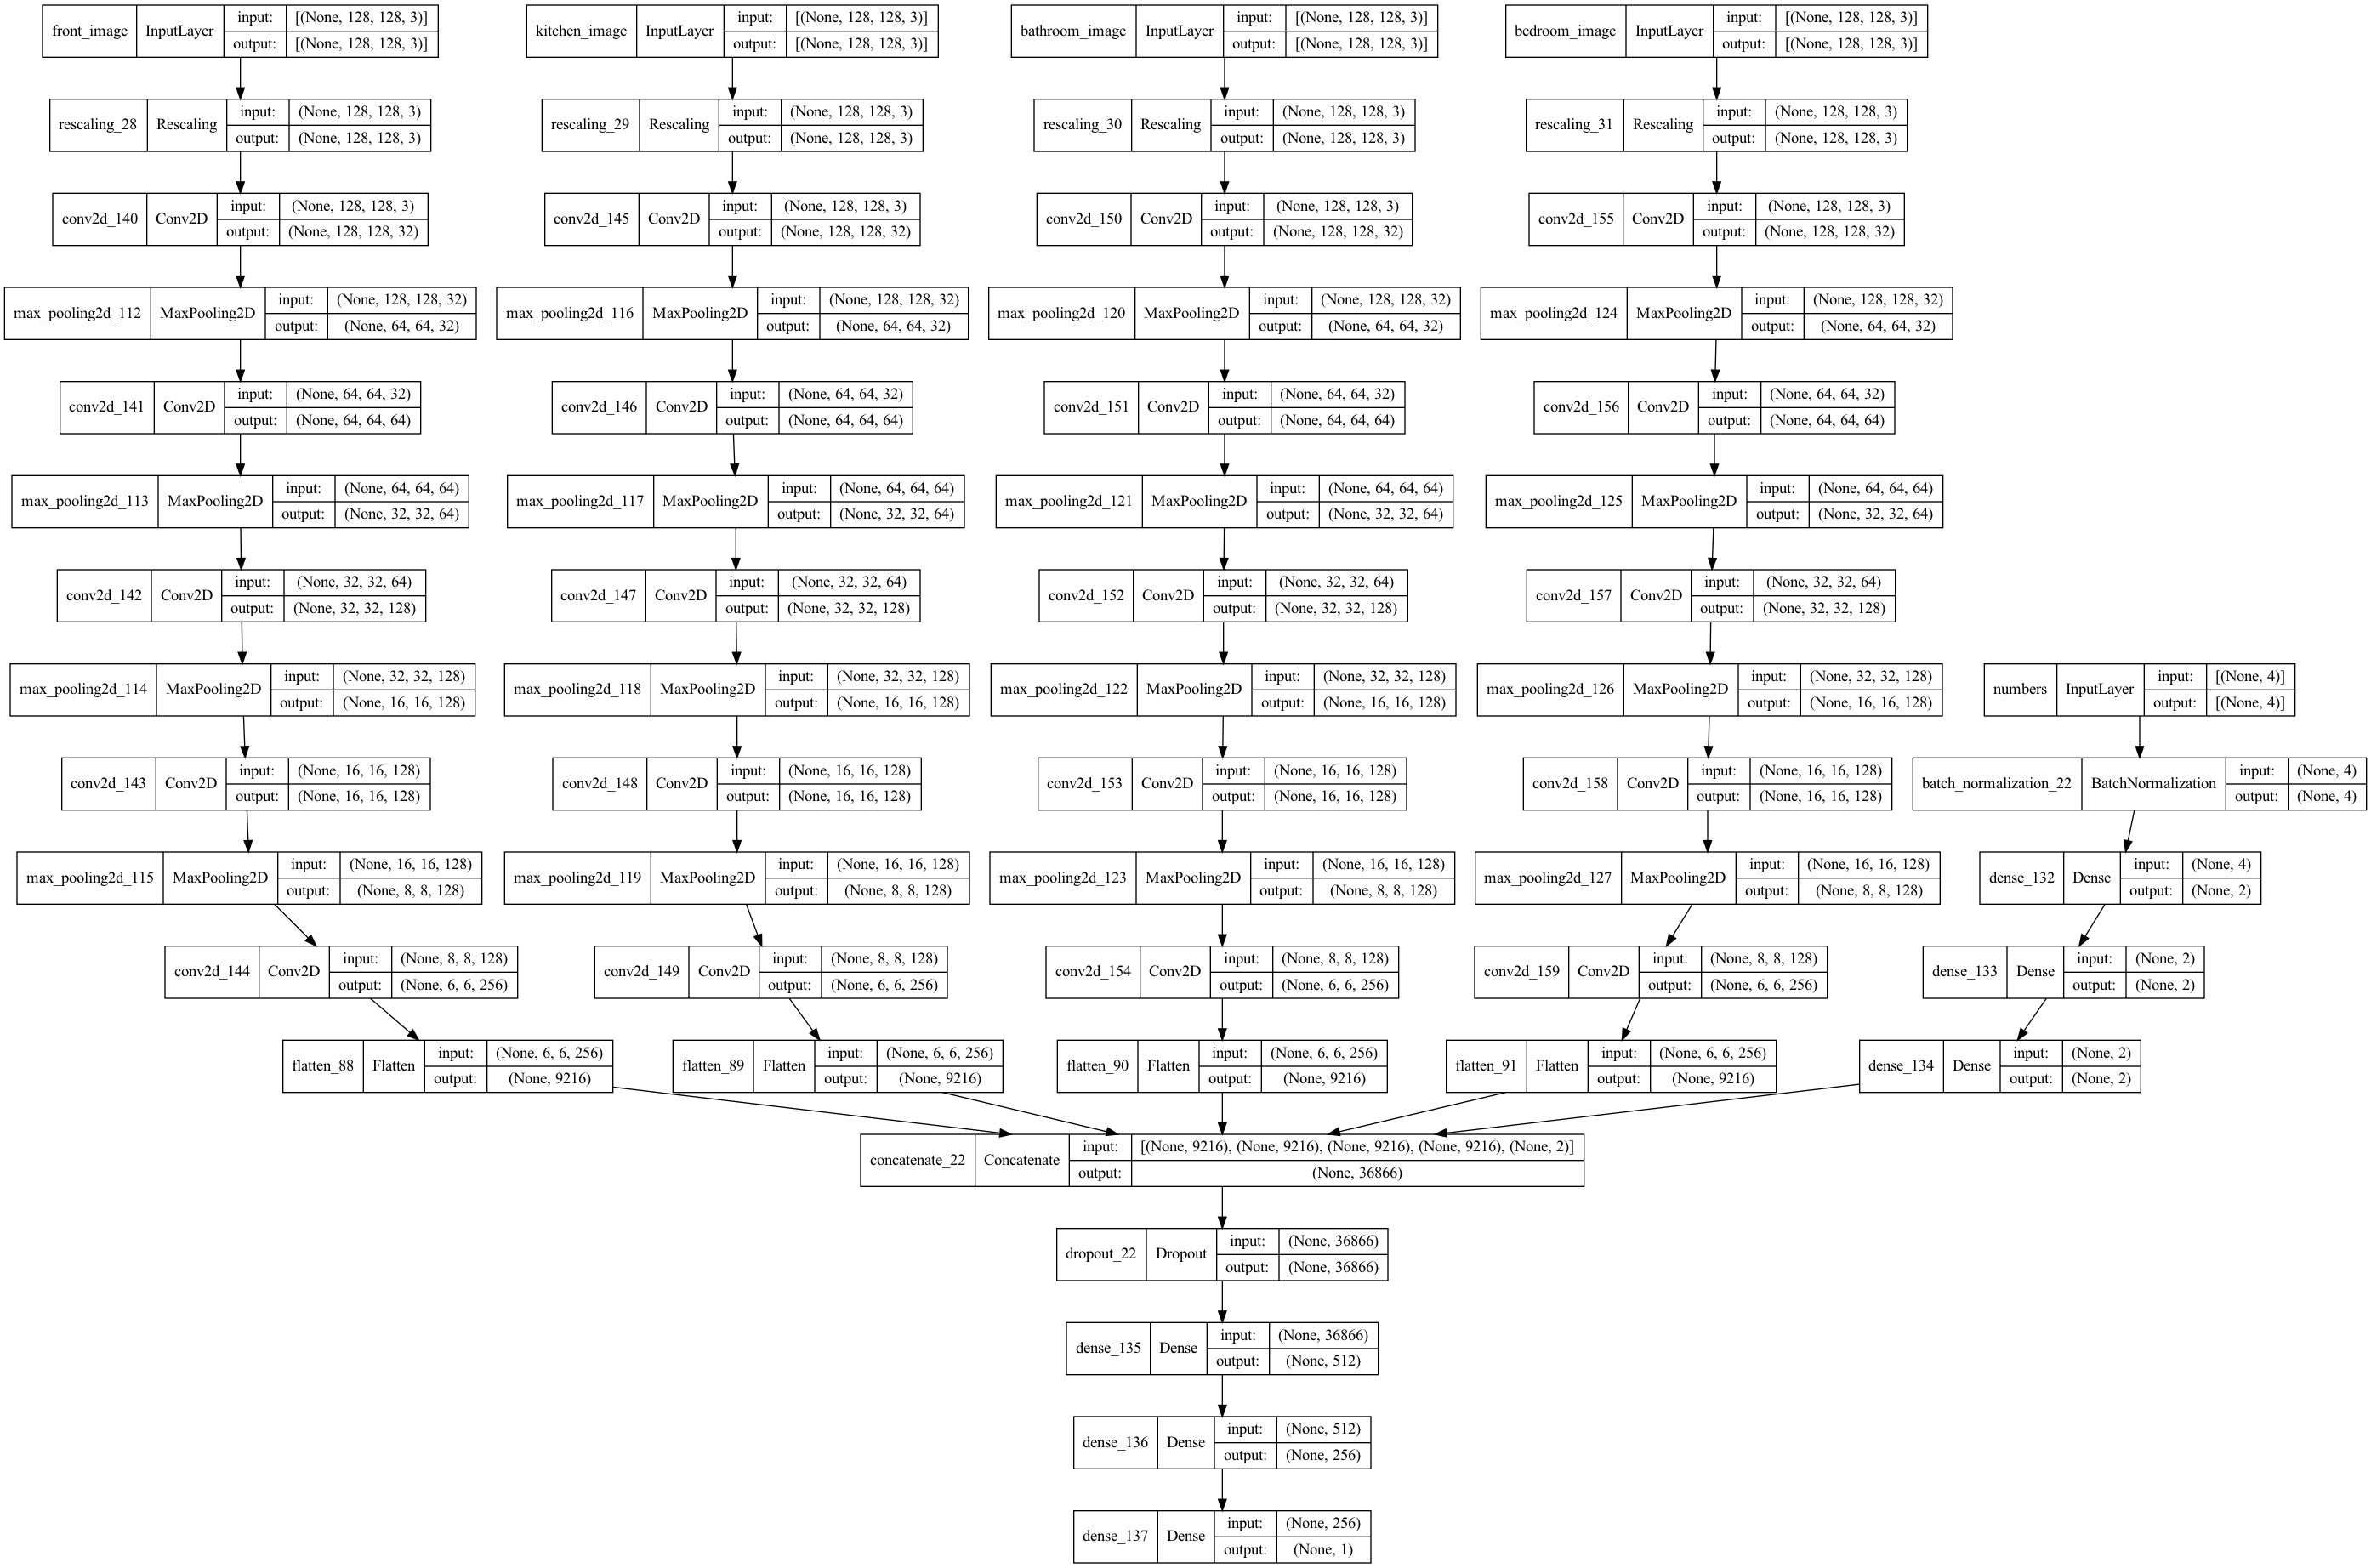

In [88]:
def build_model():

    # Define front_image input branch
    front_input = layers.Input(shape=(128, 128, 3),name = 'front_image')
    x = layers.Rescaling(1./255)(front_input) # rescale the image by dividing 255
    x = layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu")(x) # keep the same shape of input and output
    x = layers.MaxPooling2D(pool_size=2, padding="same")(x) # half size the feature map
    x = layers.Conv2D(filters=64, kernel_size=3,padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2, padding="same")(x)
    x = layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2, padding="same")(x)
    x = layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2, padding="same")(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    front_output = layers.Flatten()(x)


    # Define kitchen_image input branch
    kitchen_input = layers.Input(shape=(128, 128, 3),name = 'kitchen_image')
    x = layers.Rescaling(1./255)(kitchen_input)
    x = layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2, padding="same")(x)
    x = layers.Conv2D(filters=64, kernel_size=3,padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2, padding="same")(x)
    x = layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2, padding="same")(x)
    x = layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2, padding="same")(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    kitchen_output = layers.Flatten()(x)


    # Define bathroom_image input branch
    bathroom_input = layers.Input(shape=(128, 128, 3),name = 'bathroom_image')
    x = layers.Rescaling(1./255)(bathroom_input)
    x = layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2, padding="same")(x)
    x = layers.Conv2D(filters=64, kernel_size=3,padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2, padding="same")(x)
    x = layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2, padding="same")(x)
    x = layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2, padding="same")(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    bathroom_output = layers.Flatten()(x)



    # Define bedroom_image input branch
    bedroom_input = layers.Input(shape=(128, 128, 3),name = 'bedroom_image')
    x = layers.Rescaling(1./255)(bedroom_input)
    x = layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2, padding="same")(x)
    x = layers.Conv2D(filters=64, kernel_size=3,padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2, padding="same")(x)
    x = layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2, padding="same")(x)
    x = layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2, padding="same")(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    bedroom_output = layers.Flatten()(x)


    # Define numeric input branch
    numeric_input = layers.Input(shape=(numericData_train.shape[1]),name="numbers")
    x = layers.BatchNormalization()(numeric_input) # normalize the numeric data to reduce the possibility that one feature can have more weight on the prediction
    x = layers.Dense(2,activation="relu")(x)
    x = layers.Dense(2,activation="relu")(x)
    numeric_output = layers.Dense(2,activation="relu")(x) 


    # Merge the different input branches
    merge = layers.Concatenate()([front_output,kitchen_output, bathroom_output,bedroom_output,numeric_output])
    x = layers.Dropout(0.5)(merge) # add the dropout layer to prevent overfitting
    x = layers.Dense(512,activation="relu")(x)
    x = layers.Dense(256,activation="relu")(x)
    final_output = layers.Dense(1, activation = 'relu')(x)


    model = keras.Model(inputs=[front_input, kitchen_input, bathroom_input,bedroom_input, numeric_input],outputs=final_output)


    model.compile(loss="mae",
              optimizer="adam",
              metrics=["mae"])

    return model

model1 = build_model()
# model1.summary()
keras.utils.plot_model(model1, show_shapes=True)

## Fit Your Model



- Train your model and track validation loss in terms of MAE.

In [89]:
### PROVIDE YOUR CODE TO EVALUATE FIT / EVALUATE YOUR MODEL'S ACCURACY

# We are making a different callback so we don't overwrite our last model (we might want to compare them)
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_1.keras",
        save_best_only=True,
        monitor="val_loss"),
    
    # EarlyStopping reduce the training time by monitor the val_loss 
    keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=3)
]

# And let's fit the model.
history1 = model1.fit(
    {'front_image': front_image_train, 'kitchen_image': kitchen_image_train,'bathroom_image':bathroom_image_train, 'bedroom_image': bedroom_image_train, 'numbers':numericData_train},
    labels_train,
    epochs=20,
    batch_size = 32,
    validation_data = ( {'front_image': front_image_test, 'kitchen_image': kitchen_image_test,'bathroom_image':bathroom_image_test, 'bedroom_image': bedroom_image_test, 'numbers':numericData_test},labels_test),
    callbacks=callbacks)

Epoch 1/20


2022-02-26 13:18:51.610742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - ETA: 0s - loss: 579407.1875 - mae: 579407.1875

2022-02-26 13:18:57.694133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 8s 428ms/step - loss: 579407.1875 - mae: 579407.1875 - val_loss: 593218.3750 - val_mae: 593218.3750
Epoch 2/20
14/14 [==============================] - 5s 352ms/step - loss: 397148.8438 - mae: 397148.8438 - val_loss: 423447.3750 - val_mae: 423447.3750
Epoch 3/20
14/14 [==============================] - 4s 321ms/step - loss: 363414.6875 - mae: 363414.6875 - val_loss: 332249.5938 - val_mae: 332249.5938
Epoch 4/20
14/14 [==============================] - 4s 303ms/step - loss: 320908.6875 - mae: 320908.6875 - val_loss: 349901.2500 - val_mae: 349901.2500
Epoch 5/20
14/14 [==============================] - 4s 320ms/step - loss: 326507.0625 - mae: 326507.0625 - val_loss: 331216.8438 - val_mae: 331216.8438
Epoch 6/20
14/14 [==============================] - 4s 320ms/step - loss: 312893.1250 - mae: 312893.1250 - val_loss: 329263.0938 - val_mae: 329263.0938
Epoch 7/20
14/14 [==============================] - 5s 320ms/step - loss: 318636.2812 - mae: 318636

In [92]:
model1.evaluate({'front_image': front_image_test, 'kitchen_image': kitchen_image_test,'bathroom_image':bathroom_image_test, 'bedroom_image': bedroom_image_test, 'numbers':numericData_test}, labels_test)

4/4 [==============================] - 1s 79ms/step - loss: 345740.2188 - mae: 345740.1875


[345740.21875, 345740.1875]

In [93]:
model1.predict({'front_image': front_image_test, 'kitchen_image': kitchen_image_test,'bathroom_image':bathroom_image_test, 'bedroom_image': bedroom_image_test, 'numbers':numericData_test})

array([[462715.97],
       [462214.97],
       [459229.72],
       [460721.9 ],
       [460052.1 ],
       [457103.78],
       [461475.1 ],
       [457532.78],
       [460391.22],
       [461845.84],
       [458527.34],
       [460385.78],
       [460873.16],
       [457183.16],
       [457832.53],
       [457179.84],
       [460821.9 ],
       [462139.47],
       [461999.88],
       [458056.9 ],
       [459477.8 ],
       [459662.2 ],
       [460451.94],
       [459393.3 ],
       [461842.56],
       [458217.1 ],
       [458963.8 ],
       [457961.03],
       [457194.28],
       [459786.62],
       [458498.84],
       [458998.16],
       [456051.22],
       [459448.34],
       [460053.66],
       [458719.22],
       [457503.25],
       [458262.6 ],
       [459314.4 ],
       [459499.16],
       [456041.28],
       [456500.97],
       [460235.72],
       [459160.56],
       [459192.66],
       [461442.56],
       [461216.4 ],
       [459368.28],
       [457751.66],
       [459644.97],


- Plot your model's loss over epochs to undertand fitting / overfitting.

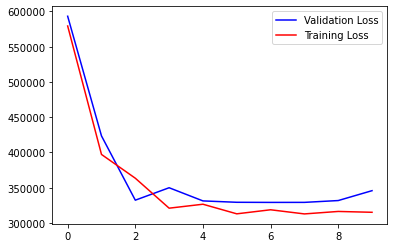

In [94]:
import matplotlib.pyplot as plt

plt.plot(history1.history['val_loss'],c="b")
plt.plot(history1.history['loss'],c="r")
plt.legend(['Validation Loss','Training Loss'])
plt.show()


# Model 2 with data augmentation to prevent overfitting

In [95]:
tf.config.set_soft_device_placement(True) 

In [96]:
with tf.device('/cpu:0'):
   data_augmentation = keras.Sequential([
      layers.RandomFlip("horizontal",input_shape = (128, 128, 3)),
      layers.RandomRotation(0.1),
      layers.RandomZoom(0.2),
   ])

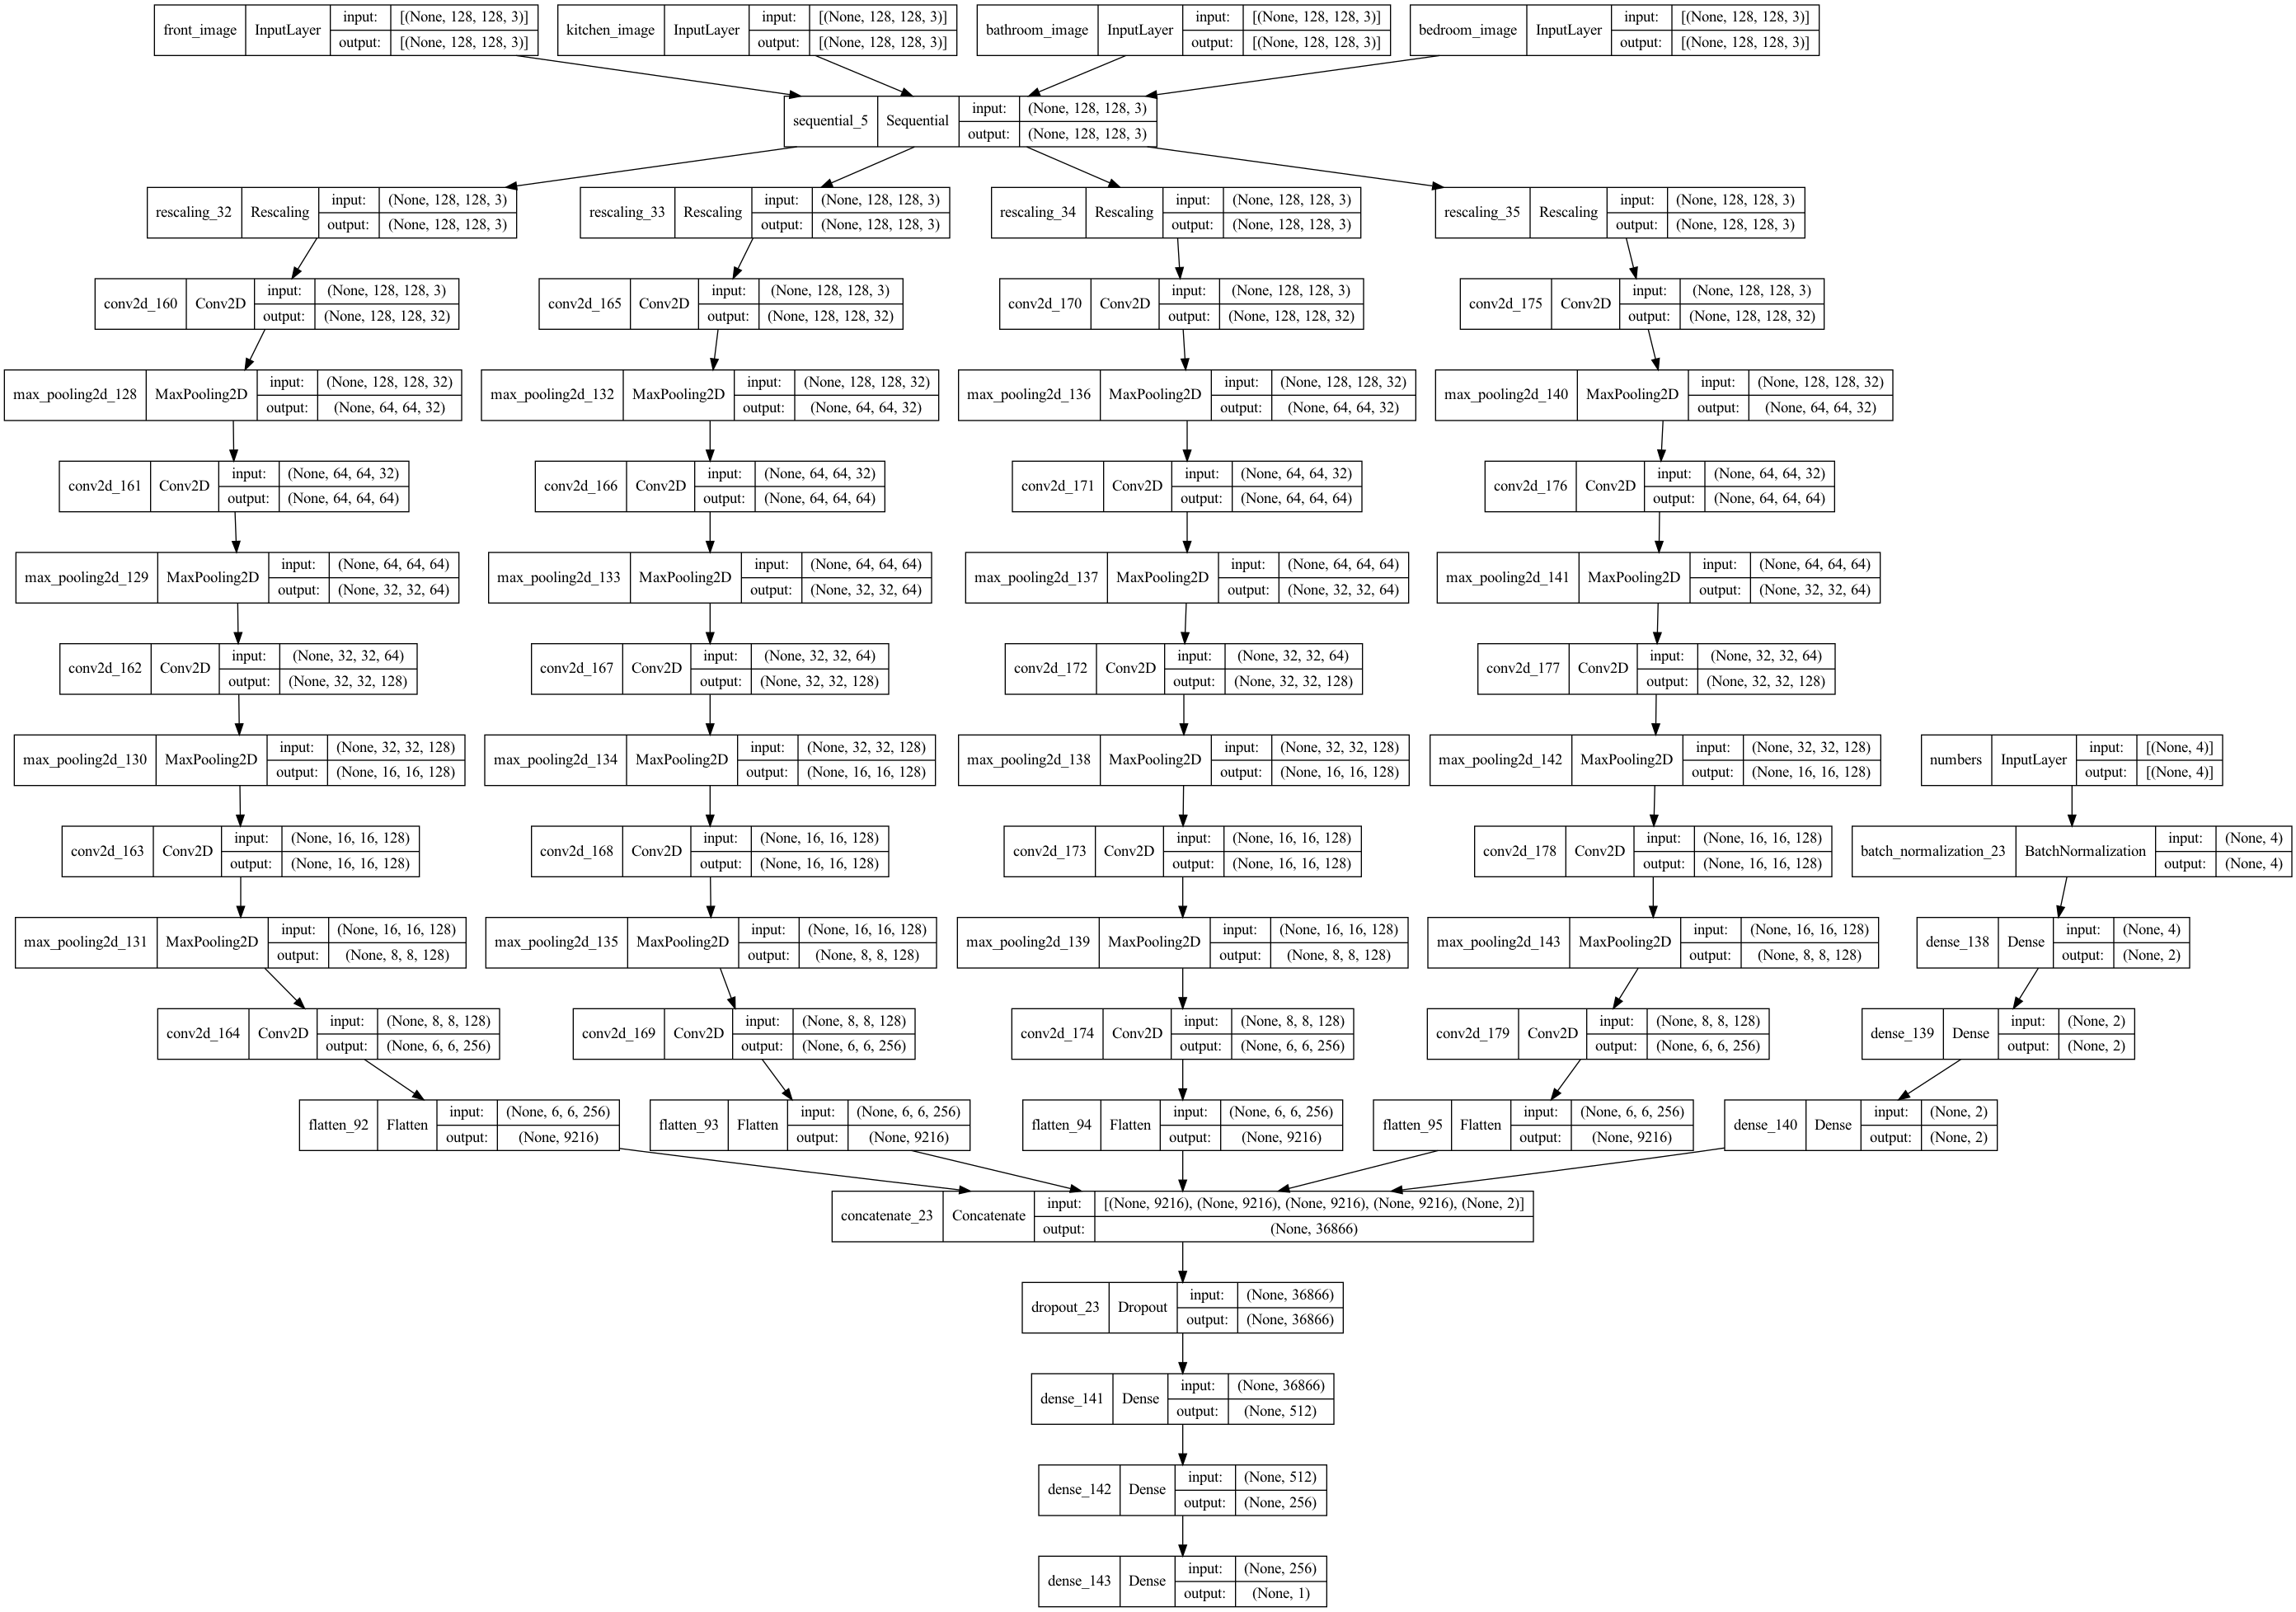

In [97]:
# almost the same setup for each branch model, the only difference is we add the data augmentation for each image model.

def build_model_2():
    # Define front_image input branch
    front_input = layers.Input(shape=(128, 128, 3),name = 'front_image')
    x = data_augmentation(front_input)
    x = layers.Rescaling(1./255)(x)
    x = layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2, padding="same")(x)
    x = layers.Conv2D(filters=64, kernel_size=3,padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2, padding="same")(x)
    x = layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2, padding="same")(x)
    x = layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2, padding="same")(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    front_output = layers.Flatten()(x)


    # Define kitchen_image input branch
    kitchen_input = layers.Input(shape=(128, 128, 3),name = 'kitchen_image')
    x = data_augmentation(kitchen_input)
    x = layers.Rescaling(1./255)(x)
    x = layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2, padding="same")(x)
    x = layers.Conv2D(filters=64, kernel_size=3,padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2, padding="same")(x)
    x = layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2, padding="same")(x)
    x = layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2, padding="same")(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    kitchen_output = layers.Flatten()(x)


    # Define bathroom_image input branch
    bathroom_input = layers.Input(shape=(128, 128, 3),name = 'bathroom_image')
    x = data_augmentation(bathroom_input)
    x = layers.Rescaling(1./255)(x)
    x = layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2, padding="same")(x)
    x = layers.Conv2D(filters=64, kernel_size=3,padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2, padding="same")(x)
    x = layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2, padding="same")(x)
    x = layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2, padding="same")(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    bathroom_output = layers.Flatten()(x)



    # Define bedroom_image input branch
    bedroom_input = layers.Input(shape=(128, 128, 3),name = 'bedroom_image')
    x = data_augmentation(bedroom_input)
    x = layers.Rescaling(1./255)(x)
    x = layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2, padding="same")(x)
    x = layers.Conv2D(filters=64, kernel_size=3,padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2, padding="same")(x)
    x = layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2, padding="same")(x)
    x = layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2, padding="same")(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    bedroom_output = layers.Flatten()(x)


    # Define numeric input branch
    numeric_input = layers.Input(shape=(numericData_train.shape[1]),name="numbers")
    x = layers.BatchNormalization()(numeric_input)
    x = layers.Dense(2,activation="relu")(x)
    x = layers.Dense(2,activation="relu")(x)
    numeric_output = layers.Dense(2,activation="relu")(x) 


    # Merge the different input branches
    merge = layers.Concatenate()([front_output,kitchen_output, bathroom_output,bedroom_output,numeric_output])
    x = layers.Dropout(0.5)(merge)
    x = layers.Dense(512,activation="relu")(x)
    x = layers.Dense(256,activation="relu")(x)
    final_output = layers.Dense(1, activation = 'relu')(x)

    model = keras.Model(inputs=[front_input, kitchen_input, bathroom_input,bedroom_input, numeric_input],outputs=final_output)

    model.compile(loss="mae",
              optimizer="adam",
              metrics=["mae"])
    
    return model

model_2 = build_model_2()

keras.utils.plot_model(model_2,show_shapes=True)

In [98]:
model_2.summary()

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 front_image (InputLayer)       [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 kitchen_image (InputLayer)     [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 bathroom_image (InputLayer)    [(None, 128, 128, 3  0           []                               
                                )]                                                         

- Train your model and track validation loss in terms of MAE.

In [99]:
### PROVIDE YOUR CODE TO EVALUATE FIT / EVALUATE YOUR MODEL'S ACCURACY

# We are making a different callback so we don't overwrite our last model (we might want to compare them)
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="hw_convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss"),
    
    keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=5)
]

# And let's fit the model.
history2 = model_2.fit(
    {'front_image': front_image_train, 'kitchen_image': kitchen_image_train,'bathroom_image':bathroom_image_train, 'bedroom_image': bedroom_image_train, 'numbers':numericData_train},
    labels_train,
    epochs=20,
    batch_size = 32,
    validation_data = ( {'front_image': front_image_test, 'kitchen_image': kitchen_image_test,'bathroom_image':bathroom_image_test, 'bedroom_image': bedroom_image_test, 'numbers':numericData_test},labels_test),
    callbacks=callbacks)

Epoch 1/20


2022-02-26 13:20:18.590770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - ETA: 0s - loss: 579398.3125 - mae: 579398.3125

2022-02-26 13:20:26.028491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 12s 473ms/step - loss: 579398.3125 - mae: 579398.3125 - val_loss: 592790.8750 - val_mae: 592790.8750
Epoch 2/20
14/14 [==============================] - 6s 401ms/step - loss: 409146.0938 - mae: 409146.0938 - val_loss: 405022.7188 - val_mae: 405022.7188
Epoch 3/20
14/14 [==============================] - 6s 441ms/step - loss: 348556.0625 - mae: 348556.0625 - val_loss: 372820.9688 - val_mae: 372820.9688
Epoch 4/20
14/14 [==============================] - 5s 382ms/step - loss: 334179.8750 - mae: 334179.8750 - val_loss: 328718.9062 - val_mae: 328718.9062
Epoch 5/20
14/14 [==============================] - 5s 362ms/step - loss: 316249.6875 - mae: 316249.6875 - val_loss: 328916.9375 - val_mae: 328916.9375
Epoch 6/20
14/14 [==============================] - 5s 371ms/step - loss: 313802.5000 - mae: 313802.5000 - val_loss: 328498.0938 - val_mae: 328498.0938
Epoch 7/20
14/14 [==============================] - 5s 373ms/step - loss: 327683.8750 - mae: 32768

- Plot your model's loss over epochs to undertand fitting / overfitting.

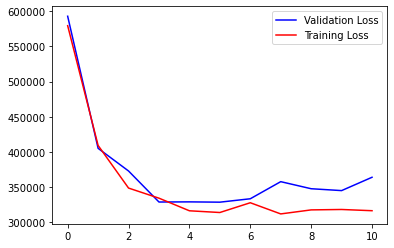

In [100]:
import matplotlib.pyplot as plt

plt.plot(history2.history['val_loss'],c="b")
plt.plot(history2.history['loss'],c="r")
plt.legend(['Validation Loss','Training Loss'])
plt.show()


In [101]:
model_2.evaluate({'front_image': front_image_test, 'kitchen_image': kitchen_image_test,'bathroom_image':bathroom_image_test, 'bedroom_image': bedroom_image_test, 'numbers':numericData_test}, labels_test)

4/4 [==============================] - 1s 126ms/step - loss: 363889.0000 - mae: 363889.0000


[363889.0, 363889.0]

# **Now Use a Pre-Trained Model (10 points)**

- In this section, you should replace the CNN components of your 'from-scratch' multi-modal network with a pre-trained model. You can use any pre-trained model you like to pre-process your images into numeric vectors, and then feed those vectors into a standard, dense feed-forward NN to generate predictions. 

##  Load Pre-Trained Model's CNN layers

In [102]:
# YOUR CODE HERE TO LOAD THE PRE-TRAINED MODEL
# We choose the VGG16 model
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(128, 128, 3))

# Freezing all layers until the fifth from the last
# Only train the weights in the last 5 layers
conv_base.trainable = True
for layer in conv_base.layers[:-5]:
  layer.trainable = False

## Pre-process Your Images Through the Pre-trained Model's CNN Layers

- You need to write a quick function that loops over your images and runs them through the pre-trained CNN layers to get back the numeric vector representations.

In [103]:
## YOUR CODE HERE TO PROCESS IMAGES THROUGH THE PRE-TRAINED MODEL AND STORE THEIR FEATURE VECTORS

def get_features(dataset):
    preprocessed_images = keras.applications.vgg16.preprocess_input(dataset)
    features = conv_base.predict(preprocessed_images)
    return features
  
front_train_features = get_features(front_image_train)
front_test_features = get_features(front_image_test)

kitchen_train_features = get_features(kitchen_image_train)
kitchen_test_features = get_features(kitchen_image_test)

bathroom_train_features = get_features(bathroom_image_train)
bathroom_test_features = get_features(bathroom_image_test)

bedroom_train_features = get_features(bedroom_image_train)
bedroom_test_features = get_features(bedroom_image_test)


# Recall we already created labels and homeFeatures data earlier, which are still numpy arrays in memory.
print(bedroom_train_features.shape)
print(labels.shape)


2022-02-26 13:21:38.790870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


(428, 4, 4, 512)
(535,)


## Define Your Dense Network (That Accepts the Image's Feature Vectors)

You will once again have a multi-branch network, but you've no longer any need for CNNs here. Just use Dense layers for each branch of input, and merge the branches together before producing a numeric prediction. Of course you may want to add elements to address overfitting.

In [104]:
tf.config.set_soft_device_placement(True) 

In [105]:
with tf.device('/cpu:0'):
   data_augmentation = keras.Sequential([
      layers.RandomFlip("horizontal",input_shape = (4, 4, 512)),
      layers.RandomRotation(0.1),
      layers.RandomZoom(0.2),
   ])

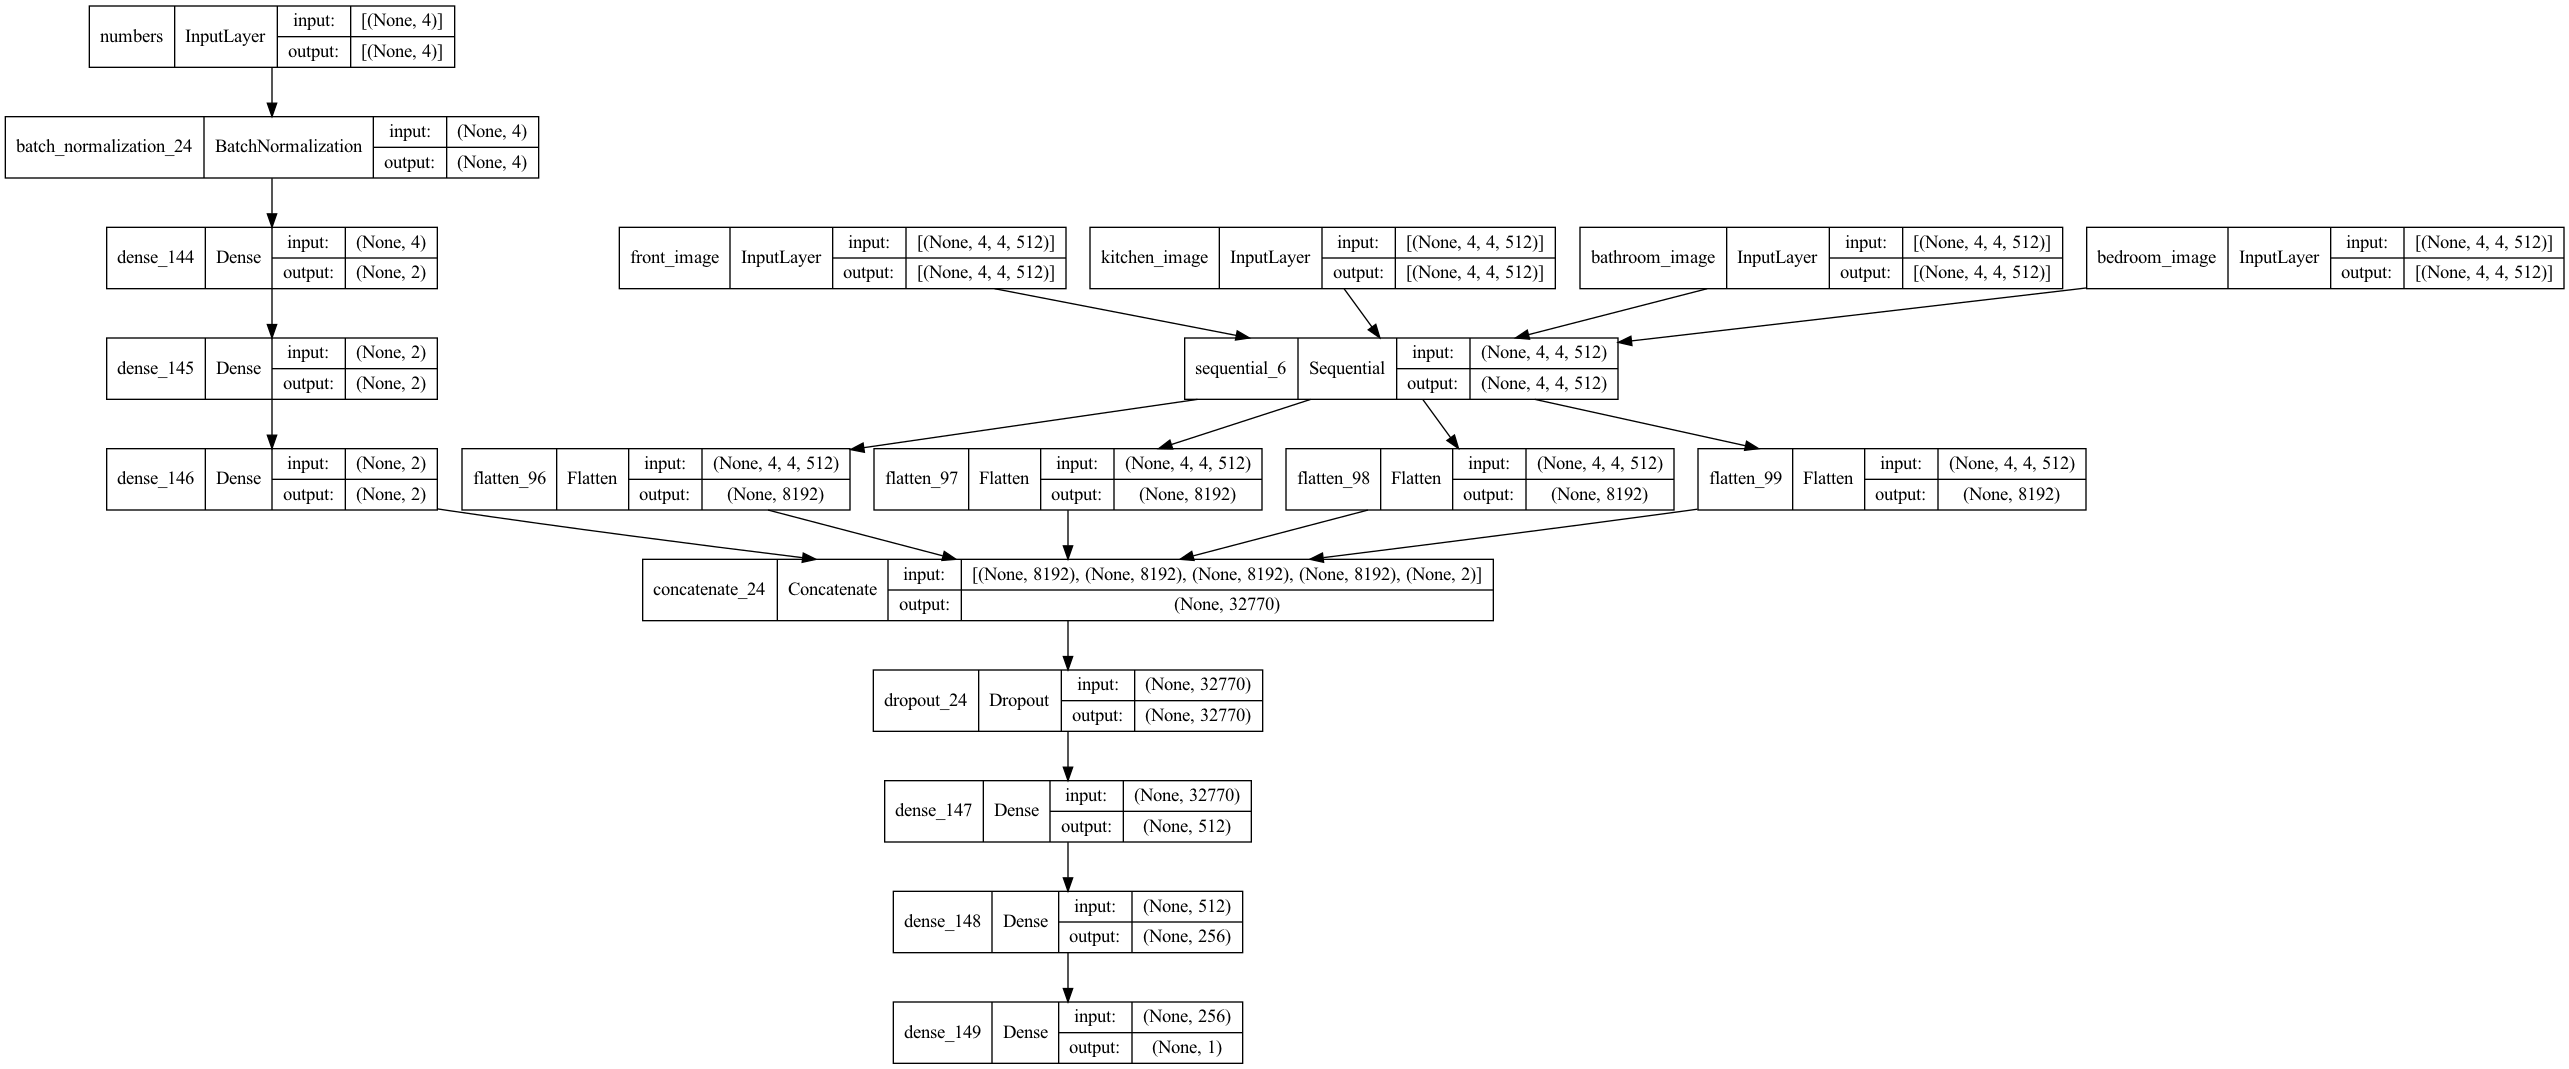

In [106]:
# use the feaures extracted from the VGG 16 models for the downstreaming prediction

def build_model_preTrain():

    ### YOUR CODE HERE TO BUILD A DENSE NETWORK ON THE FLY
    # Define front_image input branch
    front_input = layers.Input(shape=(4,4,512),name = 'front_image')
    x = data_augmentation(front_input)
    #x = layers.Rescaling(1./255)(x)
    front_output = layers.Flatten()(x)


    # Define kitchen_image input branch
    kitchen_input = layers.Input(shape=(4, 4, 512),name = 'kitchen_image')
    x = data_augmentation(kitchen_input)
    # x = layers.Rescaling(1./255)(x)
    kitchen_output = layers.Flatten()(x)


    # Define bathroom_image input branch
    bathroom_input = layers.Input(shape=(4, 4, 512),name = 'bathroom_image')
    x = data_augmentation(bathroom_input)
    # x = layers.Rescaling(1./255)(x)
    bathroom_output = layers.Flatten()(x)



    # Define bedroom_image input branch
    bedroom_input = layers.Input(shape=(4, 4, 512),name = 'bedroom_image')
    x = data_augmentation(bedroom_input)
    # x = layers.Rescaling(1./255)(x)
    bedroom_output = layers.Flatten()(x)


    # Define numeric input branch
    numeric_input = layers.Input(shape=(numericData_train.shape[1]),name="numbers")
    x = layers.BatchNormalization()(numeric_input)
    x = layers.Dense(2,activation="relu")(x)
    x = layers.Dense(2,activation="relu")(x)
    numeric_output = layers.Dense(2,activation="relu")(x) 


    # Merge the different input branches
    merge = layers.Concatenate()([front_output,kitchen_output, bathroom_output,bedroom_output,numeric_output])
    x = layers.Dropout(0.5)(merge)
    x = layers.Dense(512,activation="relu")(x)
    x = layers.Dense(256,activation="relu")(x)
    final_output = layers.Dense(1, activation = 'relu')(x)


    model_preTrain = keras.Model(inputs=[front_input, kitchen_input, bathroom_input,bedroom_input, numeric_input],outputs=final_output)
    #keras.utils.plot_model(model_preTrain,show_shapes=True)

    model_preTrain.compile(loss="mae", optimizer="adam",  metrics=["mae"])

    return model_preTrain
  
pretrain_model = build_model_preTrain()

keras.utils.plot_model(pretrain_model,show_shapes=True)

## Fit Your Dense Model

In [107]:
#cross-validation
k = 4
num_validation_samples = len(numericData_train) // k
num_epochs = 20 # how many times would you iterate the training, bigger number, the model will learn more number of times 
batch_sizes = 35  # how many samples would you use to train your data 
all_loss_histories = []
all_val_loss_histories = []  

# For each validation fold, I will train a full set of epochs, and store the history. 
for fold in range(k):
    validation_front_features = front_train_features[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    validation_kitchen_features = kitchen_train_features[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    validation_bedroom_features = bedroom_train_features[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    validation_bathroom_features = bathroom_train_features[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]            
    validation_numeric = numericData_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]                                                                                    
    validation_targets = labels_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    training_front_features = np.concatenate([
        front_train_features[:num_validation_samples * fold],
        front_train_features[num_validation_samples * (fold + 1):]])
    training_kitchen_features = np.concatenate([
        kitchen_train_features[:num_validation_samples * fold],
        kitchen_train_features[num_validation_samples * (fold + 1):]])  
    training_bedroom_features = np.concatenate([
        bedroom_train_features[:num_validation_samples * fold],
        bedroom_train_features[num_validation_samples * (fold + 1):]])
    training_bathroom_features = np.concatenate([
        bathroom_train_features[:num_validation_samples * fold],
        bathroom_train_features[num_validation_samples * (fold + 1):]])
    training_numeric = np.concatenate([
        numericData_train[:num_validation_samples * fold],
        numericData_train[num_validation_samples * (fold + 1):]])  
    training_targets = np.concatenate([
        labels_train[:num_validation_samples * fold],
        labels_train[num_validation_samples * (fold + 1):]])
    
    # output the model here

    callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction.keras",
        save_best_only=True,
        monitor="val_loss"),

    keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=5)]

    model = build_model_preTrain()
    history3 = model.fit(x = [training_front_features, training_kitchen_features, training_bedroom_features, training_bathroom_features, training_numeric], y = training_targets, 
                        validation_data = ([validation_front_features,validation_kitchen_features, validation_bedroom_features,validation_bathroom_features,validation_numeric],validation_targets), 
                        epochs=num_epochs) 
    val_loss_history = history3.history['val_loss']
    loss_history = history3.history['loss']
    all_val_loss_histories.append(val_loss_history)
    all_loss_histories.append(loss_history)

Epoch 1/20


2022-02-26 13:22:25.848859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 591905.5000 - mae: 591905.5000

2022-02-26 13:22:28.084498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 3s 143ms/step - loss: 591905.5000 - mae: 591905.5000 - val_loss: 545526.6875 - val_mae: 545526.6875
Epoch 2/20
11/11 [==============================] - 1s 67ms/step - loss: 587591.3750 - mae: 587591.3750 - val_loss: 536367.6875 - val_mae: 536367.6875
Epoch 3/20
11/11 [==============================] - 1s 61ms/step - loss: 575136.3125 - mae: 575136.3125 - val_loss: 514566.5625 - val_mae: 514566.5625
Epoch 4/20
11/11 [==============================] - 1s 73ms/step - loss: 548921.3125 - mae: 548921.3125 - val_loss: 473070.0938 - val_mae: 473070.0938
Epoch 5/20
11/11 [==============================] - 1s 74ms/step - loss: 504080.5625 - mae: 504080.5625 - val_loss: 415787.1562 - val_mae: 415787.1562
Epoch 6/20
11/11 [==============================] - 1s 54ms/step - loss: 445641.8750 - mae: 445641.8750 - val_loss: 357825.0000 - val_mae: 357825.0000
Epoch 7/20
11/11 [==============================] - 1s 52ms/step - loss: 387258.4688 - mae: 387258.4688 

2022-02-26 13:22:47.174706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 567709.2500 - mae: 567709.2500

2022-02-26 13:22:49.791059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 9s 153ms/step - loss: 567709.2500 - mae: 567709.2500 - val_loss: 618057.1250 - val_mae: 618057.1250
Epoch 2/20
11/11 [==============================] - 1s 67ms/step - loss: 563457.9375 - mae: 563457.9375 - val_loss: 608964.5000 - val_mae: 608964.5000
Epoch 3/20
11/11 [==============================] - 1s 54ms/step - loss: 551559.1250 - mae: 551559.1250 - val_loss: 587856.4375 - val_mae: 587856.4375
Epoch 4/20
11/11 [==============================] - 1s 54ms/step - loss: 526160.2500 - mae: 526160.2500 - val_loss: 547570.8125 - val_mae: 547570.8125
Epoch 5/20
11/11 [==============================] - 1s 52ms/step - loss: 482973.6250 - mae: 482973.6250 - val_loss: 490089.0625 - val_mae: 490089.0625
Epoch 6/20
11/11 [==============================] - 1s 52ms/step - loss: 429213.3125 - mae: 429213.3125 - val_loss: 427028.6250 - val_mae: 427028.6250
Epoch 7/20
11/11 [==============================] - 1s 51ms/step - loss: 368740.3438 - mae: 368740.3438 

2022-02-26 13:23:02.379100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 591156.2500 - mae: 591156.2500

2022-02-26 13:23:04.649884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 3s 124ms/step - loss: 591156.2500 - mae: 591156.2500 - val_loss: 547630.0625 - val_mae: 547630.0625
Epoch 2/20
11/11 [==============================] - 1s 62ms/step - loss: 586726.1875 - mae: 586726.1875 - val_loss: 538385.3750 - val_mae: 538385.3750
Epoch 3/20
11/11 [==============================] - 1s 56ms/step - loss: 574237.5000 - mae: 574237.5000 - val_loss: 516558.5312 - val_mae: 516558.5312
Epoch 4/20
11/11 [==============================] - 1s 53ms/step - loss: 547981.6250 - mae: 547981.6250 - val_loss: 475885.4375 - val_mae: 475885.4375
Epoch 5/20
11/11 [==============================] - 1s 53ms/step - loss: 502730.9375 - mae: 502730.9375 - val_loss: 421444.9688 - val_mae: 421444.9688
Epoch 6/20
11/11 [==============================] - 1s 52ms/step - loss: 446691.9688 - mae: 446691.9688 - val_loss: 361486.2188 - val_mae: 361486.2188
Epoch 7/20
11/11 [==============================] - 1s 61ms/step - loss: 387449.0000 - mae: 387449.0000 

2022-02-26 13:23:18.381376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 572350.1250 - mae: 572350.1250

2022-02-26 13:23:20.450822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 4s 116ms/step - loss: 572350.1250 - mae: 572350.1250 - val_loss: 604135.5000 - val_mae: 604135.5000
Epoch 2/20
11/11 [==============================] - 1s 63ms/step - loss: 567989.8125 - mae: 567989.8125 - val_loss: 595083.6250 - val_mae: 595083.6250
Epoch 3/20
11/11 [==============================] - 1s 57ms/step - loss: 555869.8750 - mae: 555869.8750 - val_loss: 573796.1875 - val_mae: 573796.1875
Epoch 4/20
11/11 [==============================] - 1s 58ms/step - loss: 530020.7500 - mae: 530020.7500 - val_loss: 533670.6875 - val_mae: 533670.6875
Epoch 5/20
11/11 [==============================] - 1s 55ms/step - loss: 486198.9062 - mae: 486198.9062 - val_loss: 476492.1562 - val_mae: 476492.1562
Epoch 6/20
11/11 [==============================] - 1s 60ms/step - loss: 430044.3438 - mae: 430044.3438 - val_loss: 410861.5625 - val_mae: 410861.5625
Epoch 7/20
11/11 [==============================] - 1s 57ms/step - loss: 373189.3750 - mae: 373189.3750 

In [108]:
np.array(all_val_loss_histories).shape

(4, 20)

In [109]:
[[x[i] for x in all_loss_histories] for i in range(num_epochs)]

[[591905.5, 567709.25, 591156.25, 572350.125],
 [587591.375, 563457.9375, 586726.1875, 567989.8125],
 [575136.3125, 551559.125, 574237.5, 555869.875],
 [548921.3125, 526160.25, 547981.625, 530020.75],
 [504080.5625, 482973.625, 502730.9375, 486198.90625],
 [445641.875, 429213.3125, 446691.96875, 430044.34375],
 [387258.46875, 368740.34375, 387449.0, 373189.375],
 [337956.9375, 322982.28125, 343655.6875, 326905.21875],
 [322345.84375, 301182.09375, 325865.625, 305660.59375],
 [322816.125, 306451.1875, 324772.96875, 309853.40625],
 [320896.875, 301732.625, 322032.125, 309374.3125],
 [321785.3125, 302503.96875, 323052.96875, 306052.84375],
 [320025.0, 304808.25, 326589.6875, 304388.15625],
 [317731.6875, 301553.6875, 322784.5625, 300871.28125],
 [318891.21875, 307632.5, 319673.28125, 306503.875],
 [319447.53125, 301049.875, 323411.09375, 310347.28125],
 [322541.53125, 300672.4375, 321584.15625, 307522.53125],
 [320673.96875, 300874.3125, 322634.65625, 309323.34375],
 [320289.375, 303645.8

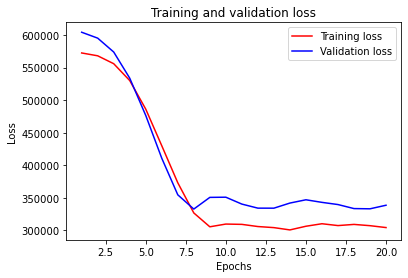

In [111]:
average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
history_dict = history3.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "r", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [112]:
# Our minimum valuation loss
min(average_val_loss_history)

309837.8671875

In [113]:
pretrain_model.evaluate({'front_image': front_test_features, 'kitchen_image': kitchen_test_features,'bathroom_image':bathroom_test_features, 'bedroom_image': bedroom_test_features, 'numbers':numericData_test}, labels_test)

2022-02-26 13:23:43.260171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 26ms/step - loss: 621270.1875 - mae: 621270.1875


[621270.1875, 621270.1875]